In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load Data
df = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia.csv')

# Drop columns
drop_columns = ["Código DIVIPOLA departamento", 
                "Nombre departamento", 
                "Código DIVIPOLA municipio",
                "Unidad de medida de edad", 
                "Pertenencia étnica", 
                "Nombre del grupo étnico",
                "Código ISO del país",
                "Nombre del país",
                "Edad",
                "Sexo",
                "Tipo de contagio",
                "Ubicación del caso",
                "Estado",
                "Tipo de recuperación"
               ]
df = df.drop(columns=drop_columns)

# Transform dates to datetime objects using the propper format
dates = ["fecha reporte web", 
         "Fecha de notificación", 
         "Fecha de inicio de síntomas", 
         "Fecha de muerte", 
         "Fecha de diagnóstico", 
         "Fecha de recuperación"
        ]
formated_dates = ["f_reporte_web", 
                  "f_notificacion", 
                  "f_ini_sintomas", 
                  "f_muerte", 
                  "f_diagnostico", 
                  "f_recuperacion"
                 ]

for i in range(len(dates)):
    print(dates[i], "\t\t--->", formated_dates[i])
    df[formated_dates[i]] = pd.to_datetime( df[dates[i]], format='%d/%m/%Y %H:%M:%S' )

df = df.drop(columns=dates)


# "Estado" column has NaN values for some cases with a valid pass-away date
# Correct those NaN with "Fallecido"
row_indexer = ~df["f_muerte"].isna() # rows with valid pass-away dates
df.loc[ (row_indexer) , "Recuperado" ] = "Fallecido" # Fix value for "Recuperado" column

print("\n")
print(df.info())

print("\nMost recent reported dates\n", df.loc[:,formated_dates].max())
df = df.drop(columns=["f_reporte_web","f_notificacion"])

fecha reporte web 		---> f_reporte_web
Fecha de notificación 		---> f_notificacion
Fecha de inicio de síntomas 		---> f_ini_sintomas
Fecha de muerte 		---> f_muerte
Fecha de diagnóstico 		---> f_diagnostico
Fecha de recuperación 		---> f_recuperacion


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71613 entries, 0 to 71612
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID de caso        71613 non-null  int64         
 1   Nombre municipio  71613 non-null  object        
 2   Recuperado        71612 non-null  object        
 3   f_reporte_web     71613 non-null  datetime64[ns]
 4   f_notificacion    71613 non-null  datetime64[ns]
 5   f_ini_sintomas    71047 non-null  datetime64[ns]
 6   f_muerte          1967 non-null   datetime64[ns]
 7   f_diagnostico     71605 non-null  datetime64[ns]
 8   f_recuperacion    66971 non-null  datetime64[ns]
dtypes: datetime64[ns](6), int64(1), object(2

/home/jc/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Print Observations with NaN in "Recuperado"
df[df["Recuperado"].isna()]

,ID de caso,Nombre municipio,Recuperado,f_ini_sintomas,f_muerte,f_diagnostico,f_recuperacion
38920,2012548,LA UVITA,NaN,2021-01-07,NaT,2021-01-22,NaT


## Resumen de casos por municipio

In [4]:
resumen = df.pivot_table(index="Nombre municipio", columns="Recuperado", values="ID de caso", aggfunc=np.count_nonzero).fillna(0)
resumen = resumen.sort_values("Activo", ascending=False)
#resumen["T"] = resumen.sum(axis=1) # Compute total observations to compare with number of "ID de caso"
resumen.astype(int).head(20)

# count "ID de caso" to compare with same calculation from the "Recuperado Column"
#df.groupby("Nombre municipio")["ID de caso"].agg(np.count_nonzero).sort_values(ascending=False)

Recuperado,Activo,Fallecido,Recuperado
Nombre municipio,,,
TUNJA,860,321,18834
DUITAMA,506,352,11952
SOGAMOSO,364,396,12180
CHIQUINQUIRA,270,134,3705
PUERTO BOYACA,88,86,2451
PAIPA,57,67,2040
MONIQUIRA,37,60,1293
VILLA DE LEYVA,32,32,575
NOBSA,28,12,897


In [5]:
# Generate dummi variables to easily create the time series
d_recuperado = pd.get_dummies(df.Recuperado, prefix='d')
d_df = pd.concat([df, d_recuperado], axis=1) 
d_df = d_df.drop(columns=["Recuperado","d_Activo"])
d_df.head()

,ID de caso,Nombre municipio,f_ini_sintomas,f_muerte,f_diagnostico,f_recuperacion,d_Fallecido,d_Recuperado
0,445,SANTANA,2020-03-13,NaT,2020-03-25,2020-04-06,0,1
1,489,TUNJA,2020-03-22,NaT,2020-03-26,2020-04-06,0,1
2,690,OICATA,2020-03-25,NaT,2020-03-29,2020-04-11,0,1
3,703,SANTANA,2020-03-18,NaT,2020-03-30,2020-04-13,0,1
4,864,TUNJA,2020-03-22,2020-04-04,2020-03-31,NaT,1,0


In [6]:
# Create time series for active, recovered, passaway
# Each time series requires to be done independently

# Create acumulate time series using pivot tables
new_cases = d_df.pivot_table(index="f_ini_sintomas", 
                                  values="ID de caso", 
                                  columns="Nombre municipio", 
                                  aggfunc=np.count_nonzero)
cum_new_cases = new_cases.sort_index(ascending=True).cumsum() 

new_rec = d_df.pivot_table(index="f_recuperacion",
                                values="d_Recuperado",
                                columns="Nombre municipio",
                                aggfunc=np.count_nonzero)
cum_rec = new_rec.sort_index(ascending=True).cumsum()

new_pa = d_df.pivot_table(index="f_muerte",
                              values="d_Fallecido",
                              columns="Nombre municipio",
                              aggfunc=np.count_nonzero)
cum_pa = new_pa.sort_index(ascending=True).cumsum()

In [7]:
# Resample all 3 time series in the same index so they can be summed
d_min = min([d_df.f_ini_sintomas.min(), d_df.f_recuperacion.min()])
d_max = max([d_df.f_ini_sintomas.max(), d_df.f_recuperacion.max()])
t_index = pd.date_range(start=d_min, end=d_max, freq='D')
print(d_min, d_max, sep="\n")

# Use pad() to fill values to the front and fillna(0) to fill NaN with 0
r_cum_new_cases = cum_new_cases.reindex(t_index).pad().fillna(0)
r_cum_rec = cum_rec.reindex(t_index).pad().fillna(0)
r_cum_pa = cum_pa.reindex(t_index).pad().fillna(0)

# Compute active cases: cumulative new cases - cummulative recovered - cummulative p.a.
active_cases = r_cum_new_cases - r_cum_rec - r_cum_pa

2020-03-13 00:00:00
2021-06-06 00:00:00


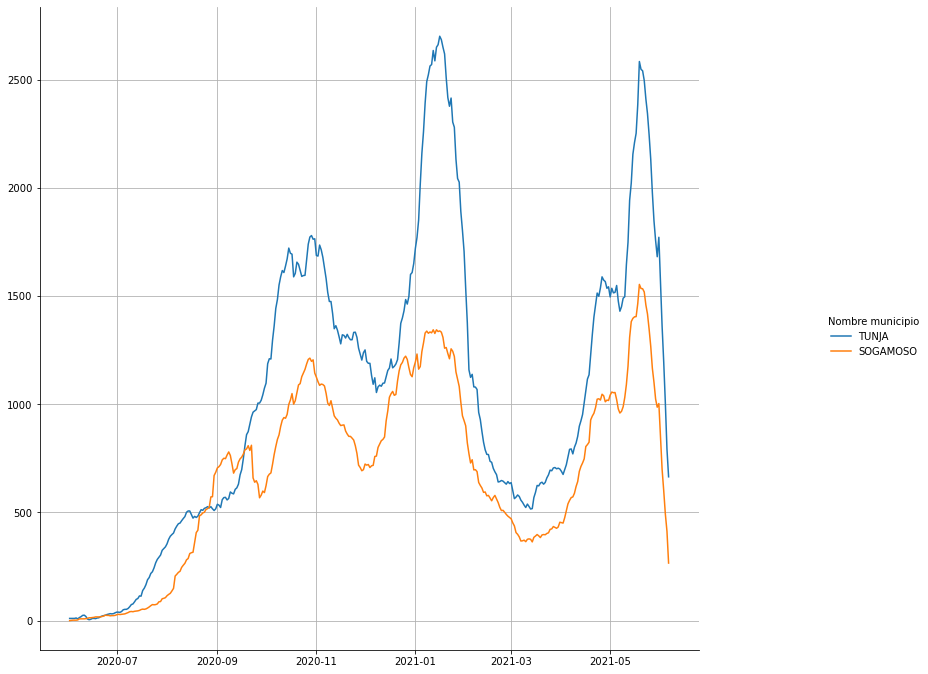

In [11]:
towns = ["TUNJA", "SOGAMOSO"]
g = sns.relplot(data=active_cases.loc[active_cases.index > "2020-06-01",towns],
           kind='line',
           dashes=False)
plt.grid()
g.fig.set_size_inches(14,10)

# Provincia Marquez

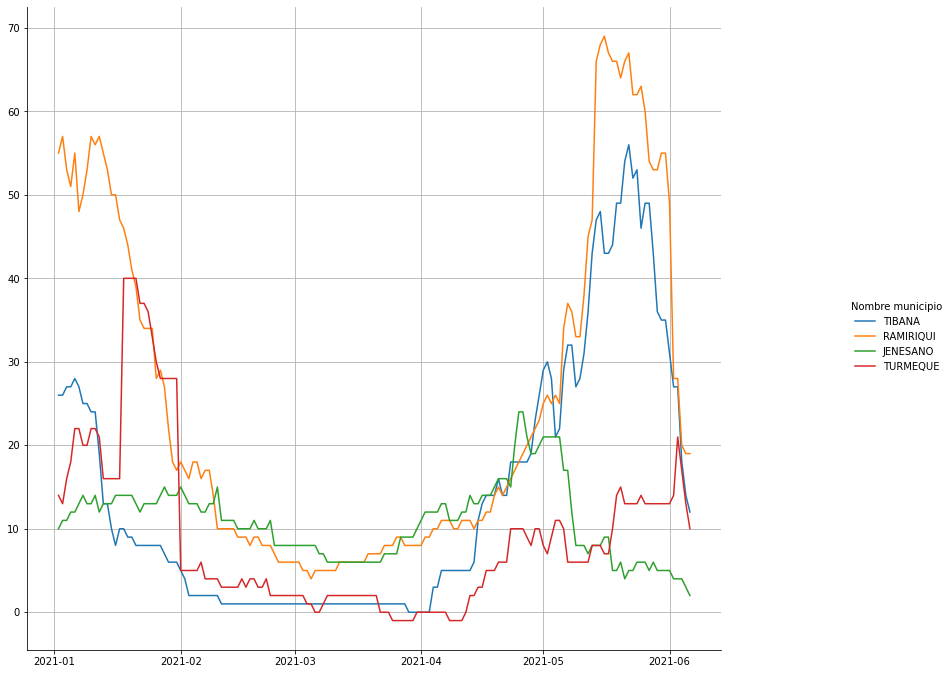

In [10]:
towns = ["TIBANA", "RAMIRIQUI", "JENESANO","TURMEQUE"]
g = sns.relplot(data=active_cases.loc[active_cases.index > "2021-01-01",towns],
           kind='line',
           dashes=False)
g.fig.set_size_inches(14,10)
plt.grid()